# Image Processing - Water detection - label 7


Idea: 
- create CCCI, NDWI2, NDTI image 
- trhresholding + filtering


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon, Patch
%matplotlib inline

import cv2

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [10]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_pansharpened, generated_upsampled_swir, generate_label_image
from image_utils import get_common_size, generate_aligned_swir
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st
from preprocessing_utils import create_pan_rad_inds_ms, create_pan_ms_swir, CCCI_index
from postprocessing_utils import normalize, binarize

In [5]:
def score(y_true, y_pred):
    smooth = 1e-12
    if len(y_true.shape) == 2: 
        y_true = y_true[:,:,None]    
    if len(y_pred.shape) == 2: 
        y_pred = y_pred[:,:,None]        
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred, axis=(0, 1))
    sum_ = np.sum(y_true + y_pred, axis=(0, 1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

In [6]:
from otb_preprocessing import compute_rm_indices_image

In [7]:
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
water_train = get_image_ids([7,], gb)

```
Web : Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
         1       2    3       4      5      6          7        8
         0       1    2       3      4      5          6        7   
```         

In [60]:
# user_channels_dict = {
#     'red': ('3b', 0),
#     'green': ('3b', 1), 
#     'blue': ('3b', 2),
#     'nir': ('ms', 7),
#     'mir': ('swir', 1)
# }

user_channels_dict = {
    'red': ('3b', 0),
    'green': ('3b', 1), 
    'blue': ('3b', 2),
    'nir': ('ms_pan', 6),
    'mir': ('ms_pan', 7)
}

## Prediction on training data

In [61]:
channels = ['ndwi2', 'ndpi', 'mndwi']

def compute_normalized_band_product(img):
    band_prod = normalize(img[:,:,0])
    for i in range(img.shape[2]):
        band_prod *= normalize(img[:,:,i])
    return band_prod[:,:,None]

In [62]:
# Load all permanent data
rad_indcs_imgs = []
y_true_list = []

for i, image_id in enumerate(water_train):
    print "--", image_id, i+1, "/", len(water_train)
    generate_pansharpened(image_id, 'ms')
    generate_aligned_swir(image_id)
    generated_upsampled_swir(image_id, 'swir_aligned')
    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi

    # concatenate normalized product:
    band_prod = compute_normalized_band_product(rad_indcs_img)
    rad_indcs_img = np.concatenate((rad_indcs_img, band_prod), axis=2)
    
    rad_indcs_imgs.append(rad_indcs_img)
    label_image = get_image_data(image_id, 'label')
    y_true = label_image[:,:,7]
    y_true_list.append(y_true)

-- 6070_2_3 1 / 2
-- 6100_2_2 2 / 2


In [63]:
params = {    
    0: (0.0, 9999, 55, 5),
    1: (-0.246875, 0.0, 55, 5),
    2: (0.13005078, 9999, 55, 5),
    3: (0.0331875, 1.0, 55, 5)
}

def water_detector(rad_indcs_img):
    sum_img = binarize(rad_indcs_img[:,:,0], *params[0])
    for i in range(rad_indcs_img.shape[2]-1):
        sum_img += binarize(rad_indcs_img[:,:,i+1], *params[i+1])
    result = (sum_img > 0.55 * rad_indcs_img.shape[2]).astype(np.uint8)
    return result

In [64]:
total_score = 0
for i, image_id in enumerate(water_train):
    print "--", image_id, i, "/", len(water_train)    
    y_true = y_true_list[i]
    bin_img = water_detector(rad_indcs_imgs[i])
    h, w = get_common_size(y_true, bin_img)    
    s = score(y_true[:h,:w], bin_img[:h,:w])
    print "Score: ",s
    total_score += s
total_score /= len(water_train)
print "Total score : ", total_score

-- 6070_2_3 0 / 2
Score:  0.786555
-- 6100_2_2 1 / 2
Score:  0.523058
Total score :  0.654806762934


-- 6070_2_3 0 / 2
-- 6100_2_2 1 / 2


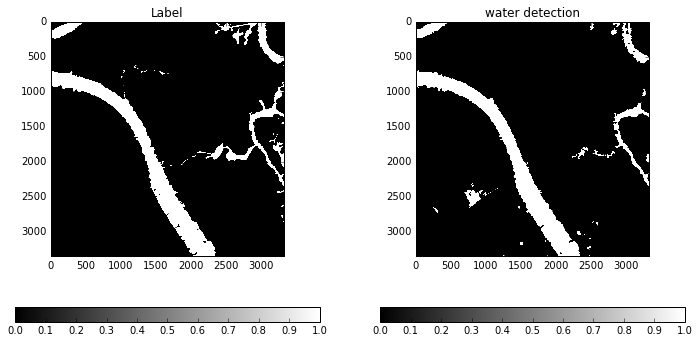

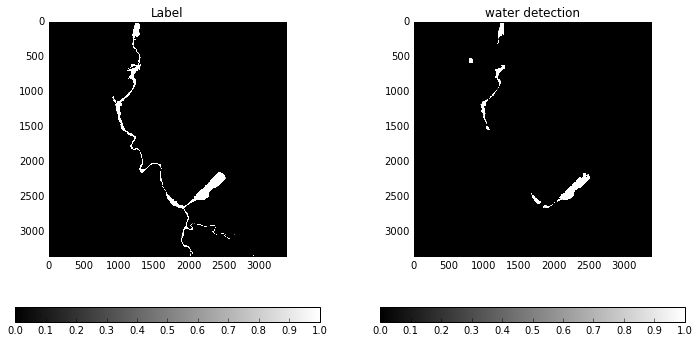

In [65]:
for i, image_id in enumerate(water_train):
    print "--", image_id, i, "/", len(water_train)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    plt.subplot(122)
    plt.title("water detection")
    bin_img = water_detector(rad_indcs_imgs[i])
    display_img_1b(bin_img)


### Check on other images without water

In [66]:
# Load all permanent data
rad_indcs_imgs = []
y_true_list = []

other_train_ids = TRAIN_IMAGE_IDS[:15]

for i, image_id in enumerate(other_train_ids):
    print "--", image_id, i+1, "/", len(other_train_ids)
    generate_pansharpened(image_id, 'ms')
    generate_aligned_swir(image_id)
    generated_upsampled_swir(image_id, 'swir_aligned')

    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi

    # concatenate normalized product:
    band_prod = compute_normalized_band_product(rad_indcs_img)
    rad_indcs_img = np.concatenate((rad_indcs_img, band_prod), axis=2)
    
    rad_indcs_imgs.append(rad_indcs_img)
    label_image = get_image_data(image_id, 'label')
    y_true = label_image[:,:,7]
    y_true_list.append(y_true)

-- 6040_2_2 1 / 15
-- 6120_2_2 2 / 15
-- 6120_2_0 3 / 15
-- 6090_2_0 4 / 15
-- 6040_1_3 5 / 15
-- 6040_1_0 6 / 15
-- 6100_1_3 7 / 15
-- 6010_4_2 8 / 15
-- 6110_4_0 9 / 15
-- 6140_3_1 10 / 15
-- 6110_1_2 11 / 15
-- 6100_2_3 12 / 15
-- 6150_2_3 13 / 15
-- 6160_2_1 14 / 15
-- 6140_1_2 15 / 15


In [67]:
total_score = 0
for i, image_id in enumerate(other_train_ids):
    print "--", image_id, i, "/", len(other_train_ids)    
    y_true = y_true_list[i]
    bin_img = water_detector(rad_indcs_imgs[i])
    h, w = get_common_size(y_true, bin_img) 
    s = score(y_true[:h,:w], bin_img[:h,:w])
    print "Score: ",s
    total_score += s
total_score /= len(other_train_ids)
print "Total score : ", total_score

-- 6040_2_2 0 / 15
Score:  1.0
-- 6120_2_2 1 / 15
Score:  1.0
-- 6120_2_0 2 / 15
Score:  1.0
-- 6090_2_0 3 / 15
Score:  1.0
-- 6040_1_3 4 / 15
Score:  1.0
-- 6040_1_0 5 / 15
Score:  2.98686e-16
-- 6100_1_3 6 / 15
Score:  2.5935e-17
-- 6010_4_2 7 / 15
Score:  1.0
-- 6110_4_0 8 / 15
Score:  8.18701e-19
-- 6140_3_1 9 / 15
Score:  1.0
-- 6110_1_2 10 / 15
Score:  2.27338e-19
-- 6100_2_3 11 / 15
Score:  8.05802e-16
-- 6150_2_3 12 / 15
Score:  1.0
-- 6160_2_1 13 / 15
Score:  1.0
-- 6140_1_2 14 / 15
Score:  1.0
Total score :  0.666666666667


In [ ]:
-- 6040_2_2 0 / 15
Score:  1.0
-- 6120_2_2 1 / 15
Score:  2.47567e-19
-- 6120_2_0 2 / 15
Score:  9.53e-19
-- 6090_2_0 3 / 15
Score:  1.0
-- 6040_1_3 4 / 15
Score:  1.0
-- 6040_1_0 5 / 15
Score:  2.98686e-16
-- 6100_1_3 6 / 15
Score:  2.16179e-17
-- 6010_4_2 7 / 15
Score:  8.79522e-20
-- 6110_4_0 8 / 15
Score:  1.36552e-18
-- 6140_3_1 9 / 15
Score:  4.05839e-19
-- 6110_1_2 10 / 15
Score:  3.15499e-19
-- 6100_2_3 11 / 15
Score:  9.73217e-18
-- 6150_2_3 12 / 15
Score:  1.53785e-18
-- 6160_2_1 13 / 15
Score:  1.0
-- 6140_1_2 14 / 15
Score:  3.05704e-19
Total score :  0.266666666667

-- 6040_2_2 0 / 15
-- 6120_2_2 1 / 15
-- 6120_2_0 2 / 15
-- 6090_2_0 3 / 15
-- 6040_1_3 4 / 15
-- 6040_1_0 5 / 15
-- 6100_1_3 6 / 15
-- 6010_4_2 7 / 15
-- 6110_4_0 8 / 15
-- 6140_3_1 9 / 15
-- 6110_1_2 10 / 15
-- 6100_2_3 11 / 15
-- 6150_2_3 12 / 15
-- 6160_2_1 13 / 15
-- 6140_1_2 14 / 15


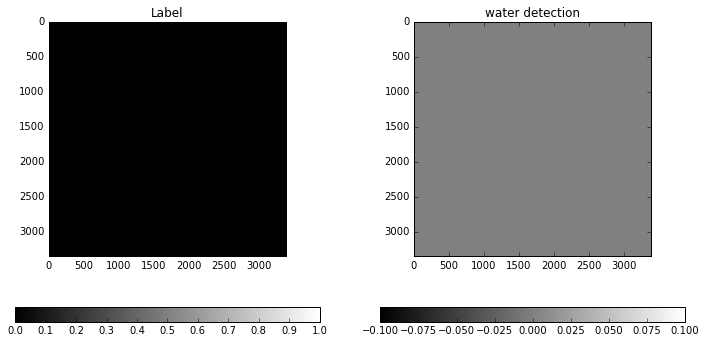

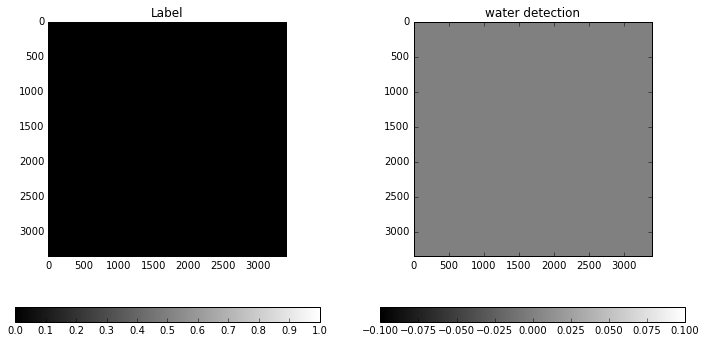

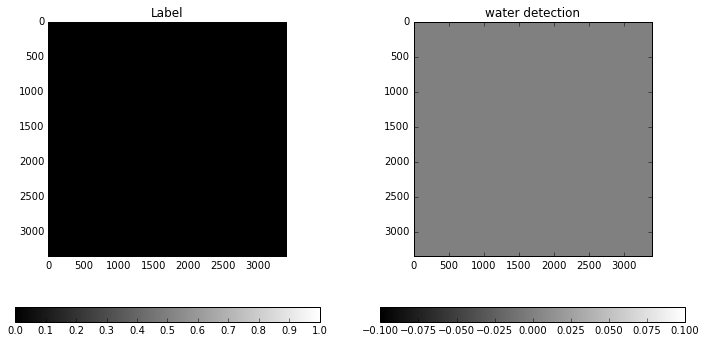

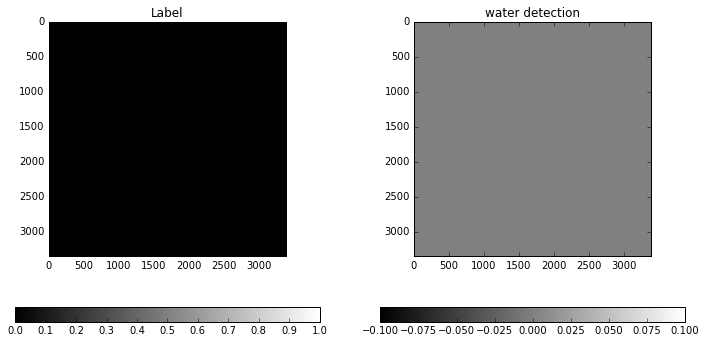

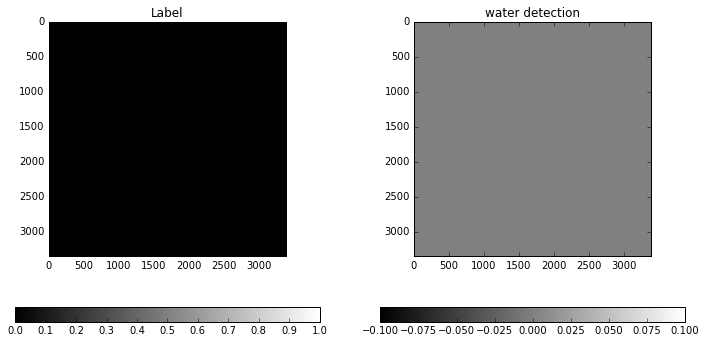

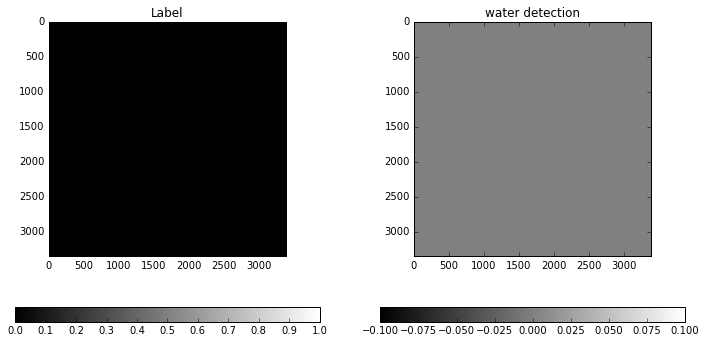

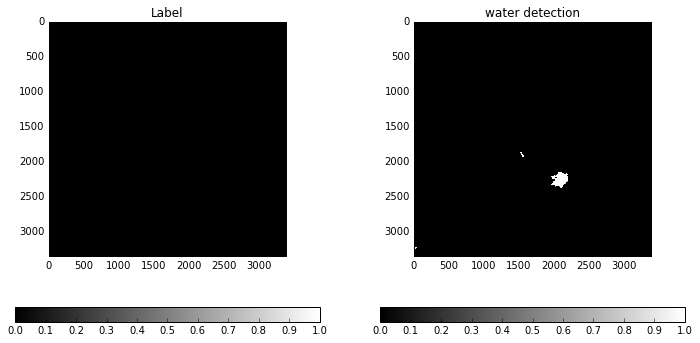

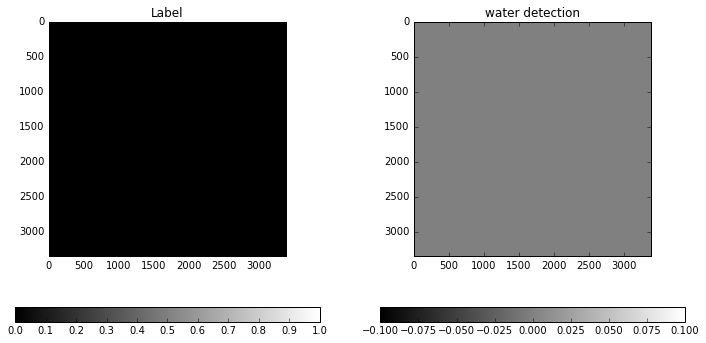

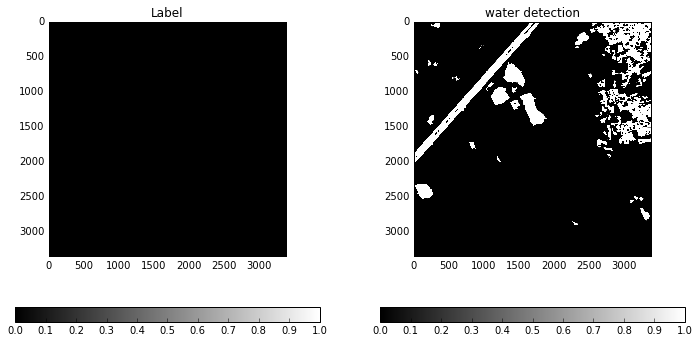

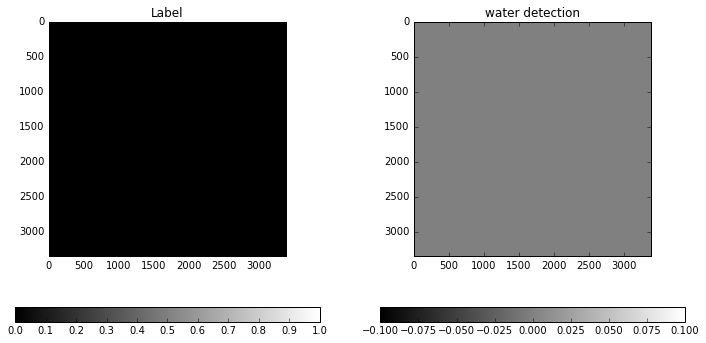

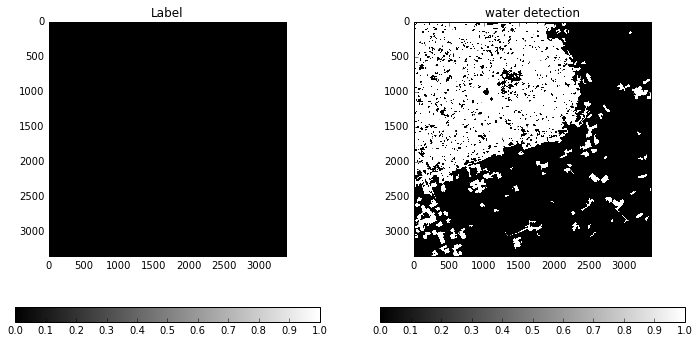

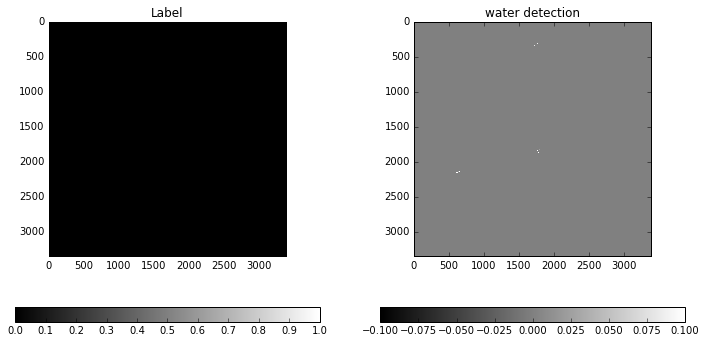

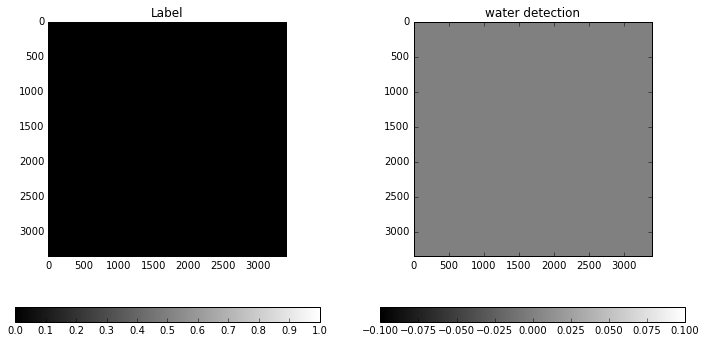

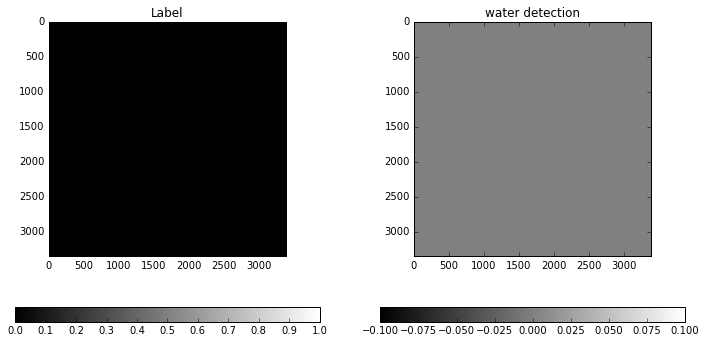

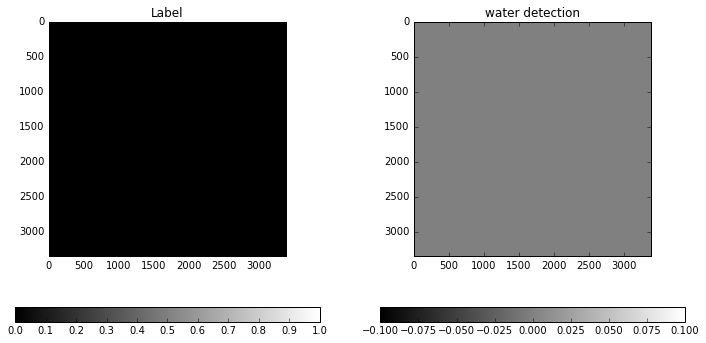

In [68]:
for i, image_id in enumerate(other_train_ids):
    print "--", image_id, i, "/", len(other_train_ids)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    plt.subplot(122)
    plt.title("water detection")
    bin_img = water_detector(rad_indcs_imgs[i])
    display_img_1b(bin_img)


## Predictions on test data

In [39]:
# Load all permanent data
rad_indcs_imgs = []
img_pan_list = []

for i, image_id in enumerate(waterway_test):
    print "--", image_id, i+1, "/", len(waterway_test)
    generate_pansharpened(image_id, 'ms')
    generate_aligned_swir(image_id)
    generated_upsampled_swir(image_id, 'swir_aligned')

    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi

    # concatenate normalized product:
    band_prod = compute_normalized_band_product(rad_indcs_img)
    rad_indcs_img = np.concatenate((rad_indcs_img, band_prod), axis=2)
    
    rad_indcs_imgs.append(rad_indcs_img)
    img_pan = get_image_data(image_id, 'pan')
    img_pan_list.append(img_pan)

-- 6080_4_3 1 / 6
-- 6080_4_0 2 / 6
-- 6080_1_3 3 / 6
-- 6080_1_1 4 / 6
-- 6150_3_4 5 / 6
-- 6050_2_1 6 / 6


## Development stuff

In [212]:
channels = ['ndwi2', 'ndpi', 'mndwi']
#image_id = waterway_test[0]
# image_id = water_train[0]
image_id = "6070_2_3"

generate_pansharpened(image_id, 'ms')


img_3b = get_image_data(image_id, '3b')
label_image = get_image_data(image_id, 'label')
y_true = label_image[:,:,8] + label_image[:,:,8]

def compute_water_indices(image_id):
    ccci_img = CCCI_index(image_id, good=True)
    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)
    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi
    return ccci_img, rad_indcs_img

ccci_img, rad_indcs_img = compute_water_indices(image_id)

In [185]:
def compute_normalized_band_product(img):
    band_prod = normalize(img[:,:,0])
    for i in range(img.shape[2]-1):
        band_prod *= normalize(img[:,:,i+1])
    return band_prod[:,:,None]

def compute_band_product(img):
    band_prod = img[:,:,0].copy()
    for i in range(img.shape[2]-1):
        band_prod *= img[:,:,i+1]
    return band_prod[:,:,None]


def compute_band_sum(img):
    band_prod = img[:,:,0].copy()
    for i in range(img.shape[2]-1):
        band_prod += img[:,:,i+1]
    return band_prod[:,:,None]


band_prod = compute_normalized_band_product(rad_indcs_img)

In [62]:
# plt_st(12, 8)
# plt.subplot(121)
# display_img_1b(y_true)
# plt.title("label")
# plt.subplot(122)
# display_img_1b(band_prod[:,:,0])
# plt.title("product")
# plt_st(12, 8)

# m = 2
# for i in range(rad_indcs_img.shape[2]):
#     if i % m == 0:
#          plt_st(12, 8)
#     plt.subplot(1, m, i % m +1)
#     display_img_1b(rad_indcs_img[:,:,i])
#     plt.title("%s" % channels[i])

Optimum search for each radiometric index

In [104]:
# channels = ['ndwi2',]
channels = ['ndwi2', 'ndpi', 'mndwi', 'ci']

In [105]:
LABELS

['None',
 'Buildings',
 'Misc. Manmade structures',
 'Road',
 'Track',
 'Trees',
 'Crops',
 'Waterway',
 'Standing water',
 'Vehicle Large',
 'Vehicle Small']

In [186]:
# Load all permanent data

rad_indcs_imgs = []
y_true_list = []

other_train_ids = TRAIN_IMAGE_IDS
# other_train_ids = water_train
dataset = tuple(water_train) + ("6110_4_0", "6110_1_2") #+ tuple(other_train_ids[:5])

for i, image_id in enumerate(dataset):
    print "--", image_id, i+1, "/", len(dataset)
    generate_pansharpened(image_id, 'ms')
    generate_aligned_swir(image_id)
    generated_upsampled_swir(image_id, 'swir_aligned')

    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

    # inverse ndpi
    ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi
        
#     # compute mixed bands with ci
#     alpha = 0.5
#     ci = rad_indcs_img[:,:,channels.index('ci')]
#     ci = ci.max() + ci.min() - ci
#     bands = [rad_indcs_img[:,:,channels.index(c)] for c in channels[:-1]]
#     for b in bands: # without ci and prod 
#         b -= ci
#         rad_indcs_img = np.concatenate((rad_indcs_img, b[:,:,None]), axis=2)
        
    # concatenate bands sum:
    bands_sum = compute_band_sum(rad_indcs_img[:,:,:])
    rad_indcs_img = np.concatenate((rad_indcs_img, bands_sum), axis=2)

    rad_indcs_imgs.append(rad_indcs_img)
    label_image = get_image_data(image_id, 'label')
    y_true = label_image[:,:,7]# + label_image[:,:,8]
    y_true_list.append(y_true)

-- 6070_2_3 1 / 4
-- 6100_2_2 2 / 4
-- 6110_4_0 3 / 4
-- 6110_1_2 4 / 4


In [191]:
count = 0

-- 6070_2_3 0 / 2


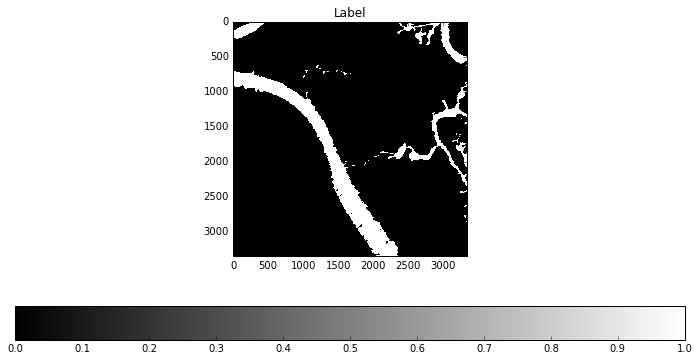

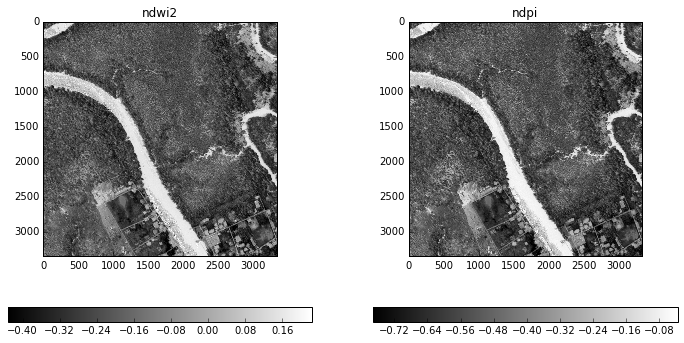

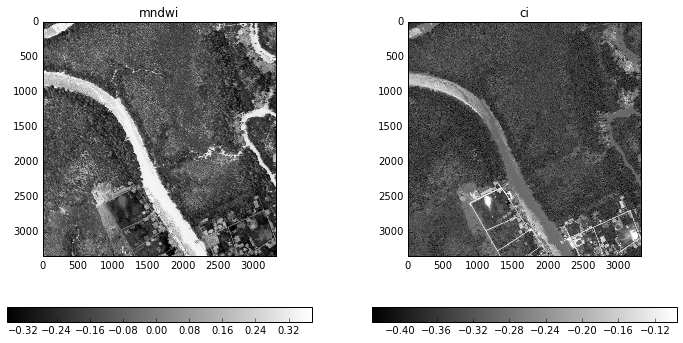

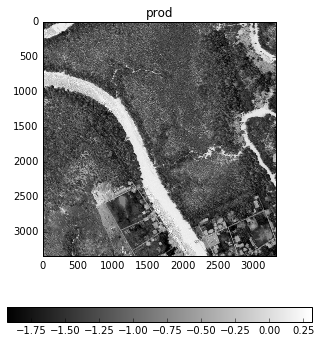

In [192]:
_channels = tuple(channels) + ('prod', ) + tuple([c+'_ci' for c in channels]) 
for i, image_id in enumerate(dataset[count:]):
    i += count
    print "--", image_id, i, "/", len(water_train)

    plt_st(12,6)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        display_img_1b(rad_indcs_imgs[i][:,:,j])
    break
count+=1

In [189]:
count=2

-- 6110_4_0 2 / 2


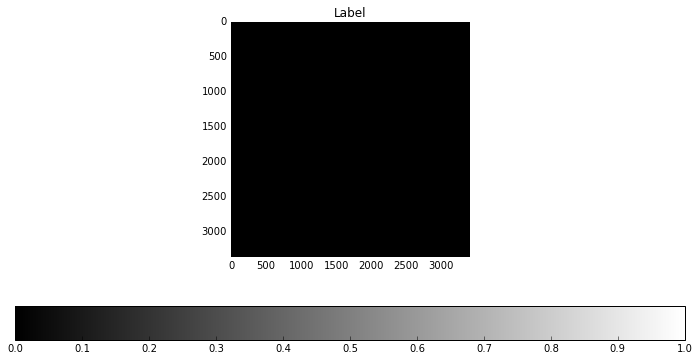

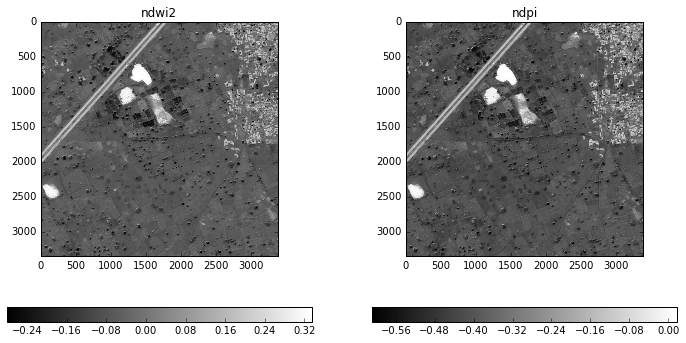

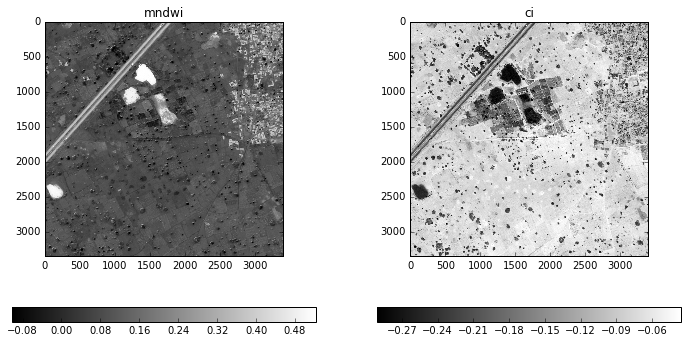

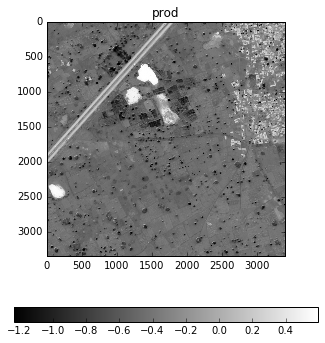

In [190]:
_channels = tuple(channels) + ('prod', ) + tuple([c+'_ci' for c in channels]) 
for i, image_id in enumerate(dataset[count:]):
    i += count
    print "--", image_id, i, "/", len(water_train)

    plt_st(12,6)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        display_img_1b(rad_indcs_imgs[i][:,:,j])
    break
count+=1

In [113]:
total_score = 0

index = 3
t1, t2, size, iters = (0.0, 999, 100, 5)

for i, image_id in enumerate(dataset):
    print "--", image_id, i, "/", len(dataset)
    y_true = y_true_list[i]
    ri_img = rad_indcs_imgs[i][:,:,index]
    h, w = get_common_size(y_true, ri_img)    
    bin_img = binarize(ri_img, t1, t2, size, iters)
    s = score(y_true[:h,:w], bin_img[:h,:w])
    
    print "Score: ",s
    total_score += s

total_score /= len(dataset)
print "Total score : ", total_score

-- 6070_2_3 0 / 4
Score:  8.31695e-19
-- 6100_2_2 1 / 4
Score:  4.54019e-18
-- 6110_4_0 2 / 4
Score:  1.0
-- 6110_1_2 3 / 4
Score:  1.0
Total score :  0.5


Brute-force search

In [82]:
from scipy import optimize

index = 0

def func(params):
    t1, t2 = params
    s = 55
#     t, s = params    
    iters = 5
    total_score = 0
    for i, image_id in enumerate(dataset):        
        y_true = y_true_list[i]
        ri_img = rad_indcs_imgs[i][:,:,index]
        h, w = get_common_size(y_true, ri_img)    
        bin_img = binarize(ri_img, t1, t2, s, int(iters))
        s = score(y_true[:h,:w], bin_img[:h,:w])
        total_score += s
    total_score /= len(dataset)
    return -total_score

# resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.05), slice(30,150,10)), full_output=True, finish=optimize.fmin)
resbrute = optimize.brute(func,(slice(0.0, 0.3, 0.01), slice(0.3, 0.9, 0.025)), full_output=True, finish=optimize.fmin)

print "Threshold : ", resbrute[0], "Score: ", -resbrute[1]

KeyboardInterrupt: 

In [162]:
params = {    
    0: (0.0, 0.3, 55, 5),
    1: (-0.246875, 0.0, 55, 5),
    2: (0.13005078, 9999, 55, 5),
    3: (0.0, 0.5, 55, 5),
    4: (0.80, 1.0, 55, 5),    
}

def water_detector(rad_indcs_img):    
    indices = list(range(rad_indcs_img.shape[2]))
    indices.remove(0)
    sum_img = binarize(rad_indcs_img[:,:,0], *params[0])
    for i in indices:
        sum_img += binarize(rad_indcs_img[:,:,i], *params[i])
    result = (sum_img > 0.55 * rad_indcs_img.shape[2]).astype(np.uint8)
    return result
    
    
total_score = 0
for i, image_id in enumerate(dataset):
    print "--", image_id, i, "/", len(dataset)    
    y_true = y_true_list[i]
    bin_img = water_detector(rad_indcs_imgs[i])
    h, w = get_common_size(y_true, ri_img)    
    s = score(y_true[:h,:w], bin_img[:h,:w])
    print "Score: ",s
    total_score += s
total_score /= len(dataset)
print "Total score : ", total_score

-- 6070_2_3 0 / 4
Score:  0.266742
-- 6100_2_2 1 / 4
Score:  0.561842
-- 6110_4_0 2 / 4
Score:  9.2885e-17
-- 6110_1_2 3 / 4
Score:  2.34192e-15
Total score :  0.207146026194


In [163]:
-- 6070_2_3 0 / 2
Score:  0.784617
-- 6100_2_2 1 / 2
Score:  0.550641
Total score :  0.667628586292

SyntaxError: invalid syntax (<ipython-input-163-c8f9a714ebc5>, line 1)

In [159]:
count = 0

-- 6070_2_3 1 / 4


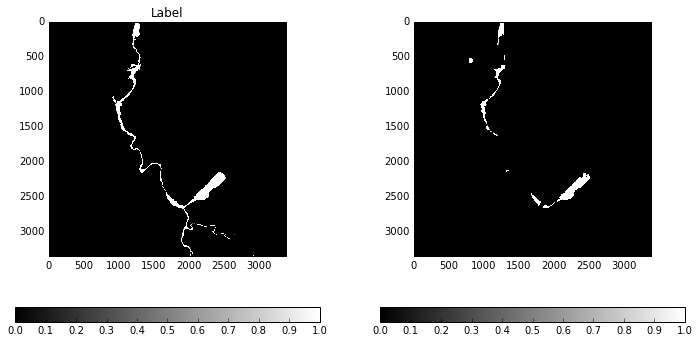

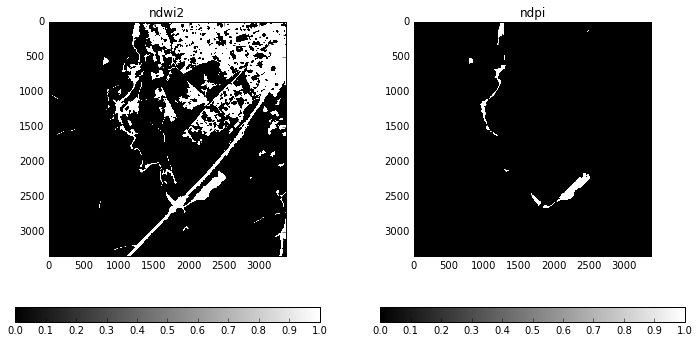

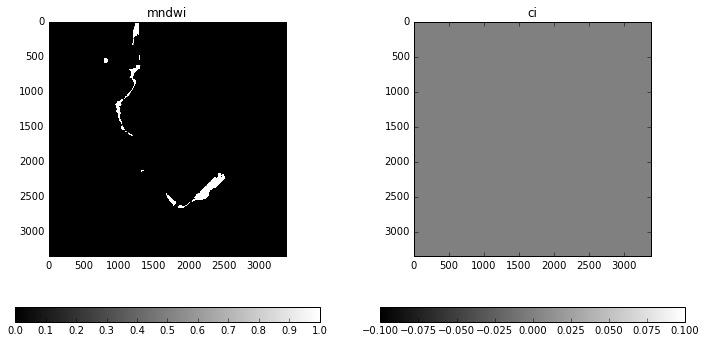

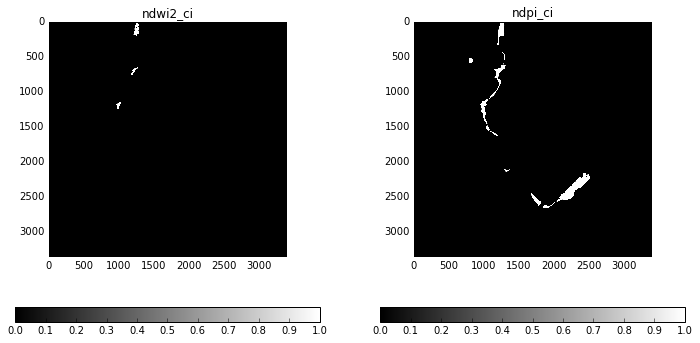

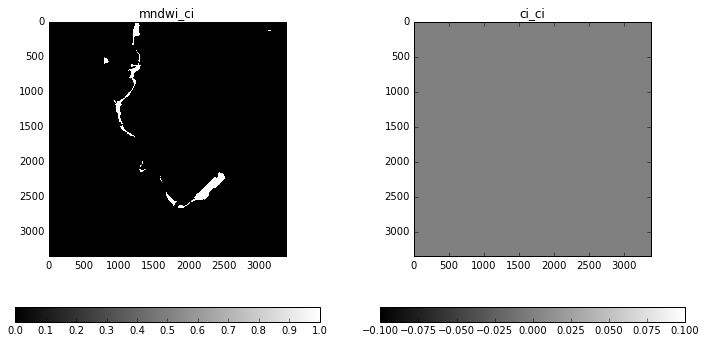

In [164]:
_channels = tuple(channels) + tuple([c+'_ci' for c in channels]) + ('prod', )

for i, image_id in enumerate(dataset):
    i += count
    print "--", image_id, i, "/", len(dataset)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    plt.subplot(122)
    display_img_1b(water_detector(rad_indcs_imgs[i]), clim=[0, 1])
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        t1, t2, size, iters = params[j]
        bin_img = binarize(rad_indcs_imgs[i][:,:,j], t1, t2, size, iters)
        display_img_1b(bin_img)
    break
count+=1

A machine learning approach

In [ ]:
train_ids = TRAIN_IMAGE_IDS


In [19]:
# plt_st(12, 8)
# plt.subplot(121)
# display_img_1b(ccci_img)
# plt.title("3b")
# plt.subplot(122)
# display_img_1b(binarize(ccci_img, 0.125, size=110, iters=3))

# print score(y_true, binarize(ccci_img, 0.125, iters=3))

In [19]:
# plt_st(12, 8)
# plt.subplot(131)
# display_img_1b(rad_indcs_img[:,:,0])
# plt.title("3b")
# plt.subplot(132)
# display_img_1b(binarize(rad_indcs_img[:,:,0], 0.5))
# plt.subplot(133)
# display_img_1b(y_true, clim=[0, 1])

In [16]:
from scipy import optimize

h, w = get_common_size(y_true, ccci_img)

def func(t):
    bin_img = binarize(ccci_img, t, size=110, iters=5)
    return -score(y_true[:h,:w], bin_img[:h,:w])

resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.025),),full_output=True, finish=optimize.fmin)

print "Threshold : ", resbrute[0], "Score: ", -resbrute[1]

Threshold :  [ 0.125] Score:  0.0244729556143


In [51]:
for i in range(rad_indcs_img.shape[2]):
    ri_img = rad_indcs_img[:,:,i]
    h, w = get_common_size(y_true, ri_img)
    
    def func(params):
        t, s, iters = params
        bin_img = binarize(ri_img, t, s, int(iters))
        return -score(y_true[:h,:w], bin_img[:h,:w])

    resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.05), slice(10, 210, 20), [1,2,3]), full_output=True, finish=optimize.fmin)

    print i, "Threshold : ", resbrute[0], "Score: ", -resbrute[1]
    break

0 Threshold :  [   0.40509521  110.30514542    1.01615532] Score:  0.783389389515


0.786956


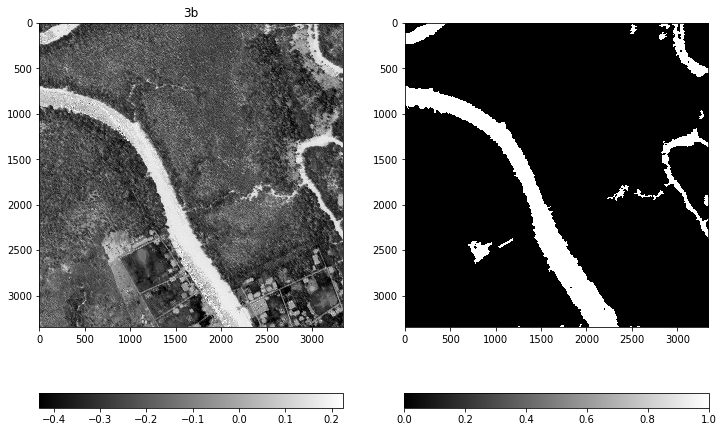

In [56]:
bin_img = binarize(ri_img, threshold=0.40509521, size=110, iters=5)
print score(y_true[:h,:w], bin_img[:h,:w])

plt_st(12, 8)
plt.subplot(121)
display_img_1b(ri_img)
plt.title("3b")
plt.subplot(122)
display_img_1b(bin_img)

In [57]:
for i in range(rad_indcs_img.shape[2]):
    ri_img = rad_indcs_img[:,:,i]
    h, w = get_common_size(y_true, ri_img)
    
    def func(t):
        bin_img = binarize(ri_img, t, size=110, iters=5)
        return -score(y_true[:h,:w], bin_img[:h,:w])

    resbrute = optimize.brute(func,(slice(0.0, 1.0, 0.025),), full_output=True, finish=optimize.fmin)

    print i, "Threshold : ", resbrute[0], "Score: ", -resbrute[1]


0 Threshold :  [ 0.4071875] Score:  0.787058591843
1 Threshold :  [ 0.42553955] Score:  0.480114012957
2 Threshold :  [ 0.45764648] Score:  0.791022181511
3 Threshold :  [ 0.45764648] Score:  0.791022181511


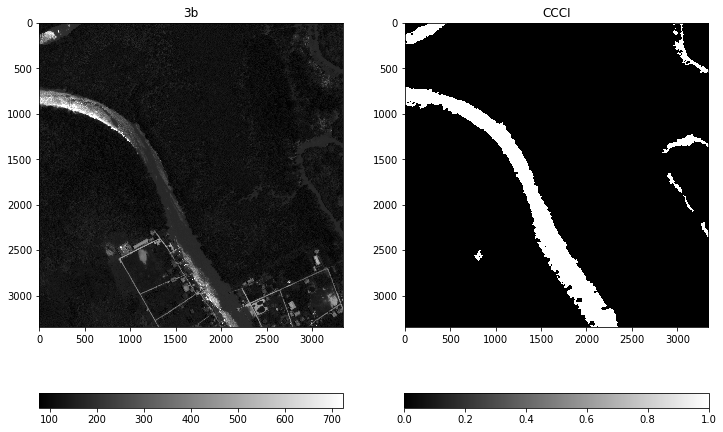

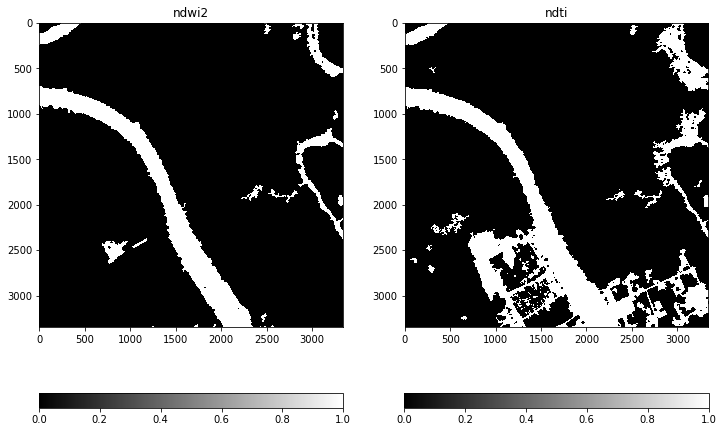

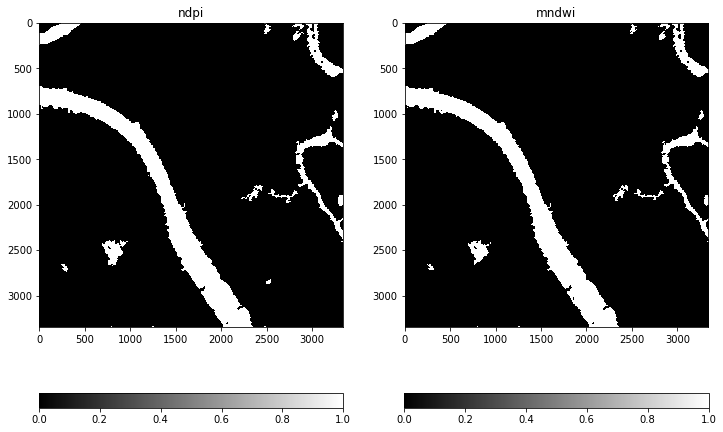

In [60]:
from ipywidgets import interact, IntSlider, FloatSlider  

def interactive_visu(t1, t2, t3, t4, t5):
    plt_st(12, 8)
    plt.subplot(121)
    display_img_1b(img_3b[:,:,0])
    plt.title("3b")
    plt.subplot(122)
    display_img_1b(binarize(ccci_img, t1*0.01, size=110, iters=5))
    plt.title("CCCI")
    
    m = 2
    tt = [t2,t3,t4,t5]
    for i in range(rad_indcs_img.shape[2]):
        if i % m == 0:
             plt_st(12, 8)
        plt.subplot(1, m, i % m +1)
        display_img_1b(binarize(rad_indcs_img[:,:,i], tt[i]*0.01, size=110, iters=5))
        plt.title("%s" % channels[i])


_ = interact(interactive_visu,           
             t1=IntSlider(value=16, min=0, max=100, continuous_update=False), 
             t2=IntSlider(value=40, min=0, max=100, continuous_update=False), 
             t3=IntSlider(value=42, min=0, max=100, continuous_update=False), 
             t4=IntSlider(value=45, min=0, max=100, continuous_update=False),
             t5=IntSlider(value=46, min=0, max=100, continuous_update=False))